### init

In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from typing import Callable, Optional
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

### read data

In [3]:
raw_dataset = fetch_openml(data_id=40975)
raw_data = raw_dataset.data.copy()
raw_data.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


### normalize data

In [4]:
# preprocessing
def f(row: pd.Series) -> pd.Series:
    unique_values = row.unique()
    values_dict = dict()
    for i, x in enumerate(unique_values):
        values_dict[x] = i

    # vectorisation
    row = row.apply(lambda v: values_dict[v]).astype('float')

    # min max scaling
    min_val, max_val = row.min(), row.max()
    row = row.apply(lambda v: (v - min_val) / (max_val - min_val))

    return row

data = raw_data.apply(f)
data

,buying,maint,doors,persons,lug_boot,safety
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.5,0.0
4,0.0,0.0,0.0,0.0,0.5,0.5
...,...,...,...,...,...,...
1723,1.0,1.0,1.0,1.0,0.5,0.5
1724,1.0,1.0,1.0,1.0,0.5,1.0
1725,1.0,1.0,1.0,1.0,1.0,0.0
1726,1.0,1.0,1.0,1.0,1.0,0.5


In [5]:
# one-hot
target = raw_dataset.target
classes = target.unique()
target_df = pd.DataFrame()
for c in classes:
    target_df[c] = target.apply(lambda x: int(x == c)).astype('int')
target_df

,unacc,acc,vgood,good
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
1723,0,0,0,1
1724,0,0,1,0
1725,1,0,0,0
1726,0,0,0,1


### algorithm

In [6]:
class KNN:
    def __init__(
            self,
            train_x: pd.DataFrame,
            train_y: pd.DataFrame,
            ker: Callable[[float], float],
            dist_f: Callable[[np.ndarray, np.ndarray], float],
            window_h: Optional[float] = None,
            window_k: Optional[int] = None
    ):
        self.train_x = train_x.to_numpy()
        self.train_y = train_y.to_numpy()
        self.ker = ker
        self.dist_f = dist_f
        self.window_h = window_h
        self.window_k = window_k

    def fit_predict(self, x: np.ndarray) -> np.ndarray:
        numerator, denominator = np.zeros(self.train_y.shape[1]), 0

        dist_x = np.asarray(list(map(lambda xi: self.dist_f(x, xi), self.train_x)))
        bound = self.window_h if self.window_h else np.partition(dist_x, self.window_k)[self.window_k]
        valuable_ind = list(filter(lambda i: dist_x[i] < bound, range(len(dist_x))))

        if len(valuable_ind) == 0:
            return np.average(y_train)

        for i in valuable_ind:
            w = self.ker(dist_x[i] / bound)
            numerator += self.train_y[i] * w
            denominator += w

        return numerator / denominator

### hyperparameters

In [7]:
# distances
def euclidean(p1: np.ndarray, p2: np.ndarray) -> float:
    return np.sqrt(np.sum((p1 - p2)**2))

def manhattan(p1: np.ndarray, p2: np.ndarray) -> float:
    return sum(np.abs(p1 - p2))

def chebyshev(p1: np.ndarray, p2: np.ndarray) -> float:
    return max(np.abs(p1 - p2))

# kernel functions
def uniform(u: float) -> float:
    return 1/2

def triangular(u: float) -> float:
    return 1 - abs(u)

def epanechnikov(u: float) -> float:
    return 3/4 * (1 - u**2)

def quartic(u: float) -> float:
    return 15/16 * (1 - u**2)**2

# window
sqrt_len = math.sqrt(len(data))
k_range = range(int(sqrt_len))

def get_h_range(dist_f: Callable[[np.ndarray, np.ndarray], float]) -> np.ndarray:
    min_dist, max_dist = None, None
    m = data.to_numpy()

    for i1 in range(len(data)):
        for i2 in range(i1):
            dist1 = dist_f(m[i1], m[i2])
            if max_dist is None or dist1 > max_dist:
                max_dist = dist1
            if min_dist is None or dist1 < min_dist:
                min_dist = dist1

    step = max_dist / sqrt_len
    return np.arange(max(step, min_dist), max_dist + step/2, step)

### F-score

In [8]:
def f_score(y_test: np.ndarray, y_pred: np.ndarray, b: int = 1) -> float:
    test_ind = np.argmax(y_test)  # actual class
    pred_ind = np.argmax(y_pred)  # predicted class
    s = 0
    for i in range(len(y_test)):  # f_score for class i
        true_positive = int(i == test_ind == pred_ind)
        false_positive = int((test_ind != i) and (pred_ind == i))
        true_negative = int((test_ind == i) and (pred_ind != i))
        false_negative = int((test_ind != i) and (pred_ind != i))

        if true_positive + false_positive == 0 or true_positive + false_negative == 0:
            continue

        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)

        if precision == recall == 0:
            continue
        s += (1 + b**2) * precision * recall / ((b**2 * precision) + recall)
    return s / len(y_test)

### leave-one-out

In [9]:
def find_best_params():
    score = 0
    best_params = [None, None, None]

    for dist_f in [euclidean, manhattan, chebyshev]:
        for ker in [uniform, triangular, epanechnikov, quartic]:
            for window_h in get_h_range(dist_f):
                print("Testing: ", dist_f.__name__, ker.__name__, f"H{window_h}")

                f = 0
                for i in tqdm(range(len(data))):
                    x_train, x_test = data.drop(i), data.iloc[i].to_numpy()
                    y_train, y_test = target_df.drop(i), target_df.iloc[i].to_numpy()
                    model = KNN(x_train, y_train, ker, dist_f, window_h=window_h)
                    y_pred = model.fit_predict(x_test)
                    f += f_score(y_test, y_pred)

                f /= len(data)

                if f > score:
                    score = f
                    best_params = [dist_f, ker, ["H", window_h]]

            for window_k in k_range:
                print("Testing: ", dist_f.__name__, ker.__name__, f"K{window_k}")

                f = 0
                for i in tqdm(range(len(data))):
                    x_train, x_test = data.drop(i), data.iloc[i].tolist()
                    y_train, y_test = target_df.drop(i), target_df.iloc[i].tolist()
                    model = KNN(x_train, y_train, ker, dist_f, window_k=window_k)
                    y_pred = model.fit_predict(x_test)
                    f += f_score(y_test, y_pred)

                f /= len(data)

                if f > score:
                    score = f
                    best_params = [dist_f, ker, ["K", window_k]]

    return best_params

# best_params = find_best_params()
best_params = [manhattan, triangular, ['K', 12]]

### analyse

41


  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

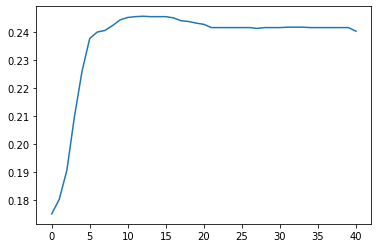

In [10]:
dist_f, ker, window = best_params
f_curve = []

window_range = get_h_range(dist_f) if window[0] == "H" else k_range
print(len(window_range))
for window_param in window_range:
    f = 0
    for i in tqdm(range(len(data))):
        x_train, x_test = data.drop(i), data.iloc[i].tolist()
        y_train, y_test = target_df.drop(i), target_df.iloc[i].tolist()
        if window[0] == "H":
            model = KNN(x_train, y_train, ker, dist_f, window_h=window_param)
        else:
            model = KNN(x_train, y_train, ker, dist_f, window_k=window_param)
        y_pred = model.fit_predict(x_test)
        f += f_score(y_test, y_pred)
    f_curve.append(f / len(data))

plt.plot(window_range, f_curve)
plt.show()